In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import librosa
import os, json, glob
import matplotlib.pyplot as plt
import librosa
import numpy as np
from f0_analysis_utils import *

## Preprocessing: filter the mono segments
Remove a segment if
1. its duration (after removing leading and trailing zeros) is too short (200ms arbitary threshold)
2. its annotation is empty

In [62]:
# remove a segment if its trimmed duration is shorter than DUR_THRES
# pure silence segments won't be removed by this because they won't be trimmed
# one frame 2048 / 44100 = 0.046 seconds
DUR_THRES = 0.2 # seconds
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments_filtered"
FILTERED_ANNO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_annotations_filtered"

for file in glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav")):
    anno_file = find_anno(file, anno_dir=FILTERED_ANNO_DIR)
    y, sr = librosa.load(file, sr=None)
    y_trimmed, _ = librosa.effects.trim(y)
    dur = librosa.get_duration(y_trimmed, sr=sr)
    if dur < DUR_THRES:
        os.remove(file)
        os.remove(anno_file)
        segment_name = file.split("/")[-1]
        print(f"removed {segment_name}")
# this removed 2315 segments

removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_46_129s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_47_130s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_50_132s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_53_137s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_58_142s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_71_213s.wav
removed Adele - Rolling In The Deep_Acoustic guitar (muted)_0_152s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_49_282s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_50_282s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_51_283s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_52_284s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_53_285s.wav
removed Avenged Sevenfold - Afterlife_  Synyster Gates - Rhythm_54_285s.wav

In [64]:
# remove a segment if its annotation is empty
# many files removed in the last step will also be removed at this step
# pure silence will be removed at this step
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments_filtered"
FILTERED_ANNO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_single_track_annotations_filtered"

for file in glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav")):
    anno_file = find_anno(file, anno_dir=FILTERED_ANNO_DIR)
    with open(anno_file) as annotation:
        anno = json.load(annotation)
    if len(anno) == 0:
        os.remove(file)
        os.remove(anno_file)
        segment_name = file.split("/")[-1]
        print(f"removed {segment_name}")
# this removed 4235 segments (when run on its own)
# this removed another 3273 segments (when run after the last cell)

removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_0_3s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_10_20s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_11_21s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_13_25s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_14_26s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_16_30s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_17_31s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_19_35s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_1_5s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_20_36s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_22_40s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_23_41s.wav
removed ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_2

## Segment the F0 curve and recognize candidate regions

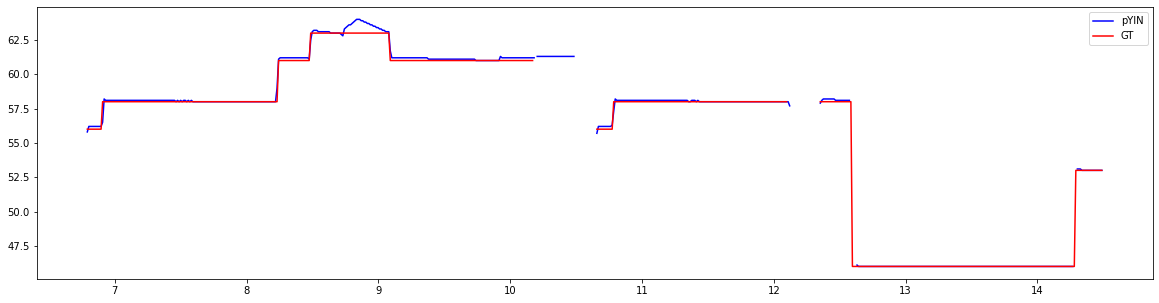

In [5]:
file = "Guns N' Roses - Welcome To The Jungle (ver 3)_Solo Guitar_0_0s.wav"
plot_f0_vs_gt(file)

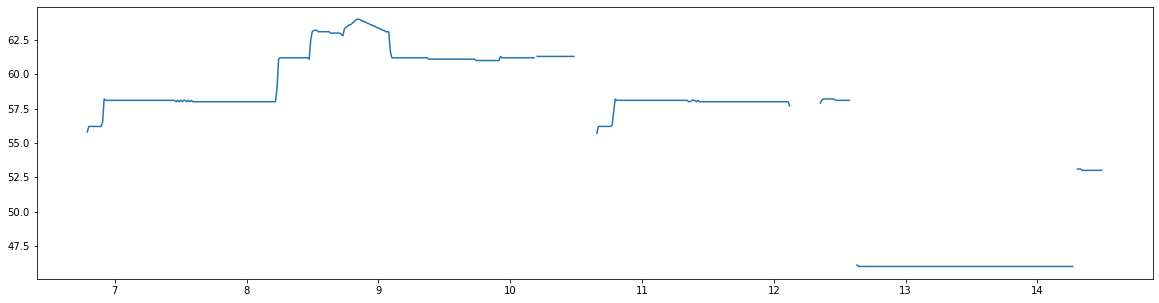

In [4]:
# the directory for preprocessed audio files (mono audio segments that has a reasonable length)
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments_filtered"
# an example file to visualize
file = "Guns N' Roses - Welcome To The Jungle (ver 3)_Solo Guitar_0_0s.wav"
file = os.path.join(FILTERED_AUDIO_DIR, file)
y, sr = librosa.load(file, sr=None)
# use pYIN to estimate F0
f0, _, _ = librosa.pyin(
    y, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("G6"), sr=sr, center=False
)
times = librosa.times_like(f0, sr=sr, hop_length=512, n_fft=2048)
# convert F0 sequence to MIDI note sequence
notes = librosa.hz_to_midi(f0)
plt.figure(figsize=(20,5))
plt.plot(times, notes)

### Split the estimated F0 curve at NaN, into segments
NaN in the F0 curve marks the discontinuity (silence) in the F0. The segments around the silence must belong to two separate note events. 
So we first split F0 into segments and then cut the segments into note events.

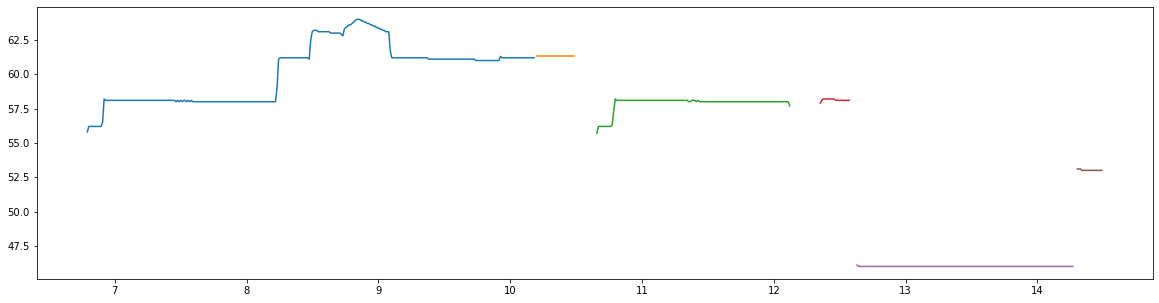

In [8]:
# a duration threshold of 80 ms is imposed on both F0 segments and note events
# too short segments and events will not be returned
f0_segments = get_continous_f0_segments(notes)
# each f0 segment marks a continuous F0 segment
plt.figure(figsize=(20,5))
for segment in f0_segments:
    plt.plot(times[segment], notes[segment])
# next I should split each F0 segment into note events

### Group adjacent F0 frames into a single note event if their pitch difference is smaller than a semitone (100 cents)

We focus on bend, slide, hammer-on, pull-off, and vibrato. \
Bend/slide/vibrato should not introduce sudden frequency changes. \
Hammer-on/pull-off may introduce sudden frequency changes. 

Observation: using 2048 framesize, hammer-on instance will cause a two-semitone freq change in one frame, and will be separated into two note events. 

This is ok, but try a smaller framesize and see what happens. \
Smaller framesize will introduce NaNs freqs in between the hammer-on instance, inevitably breaking it into two note events. Also, F0 estimation is worse when using 1024 framesize. 

What about a larger framesize? \
Larger framesize tend to merge note events together. A normal note (8.46s) and a following bend-release (8.70s) are merged into one note event in this example. 

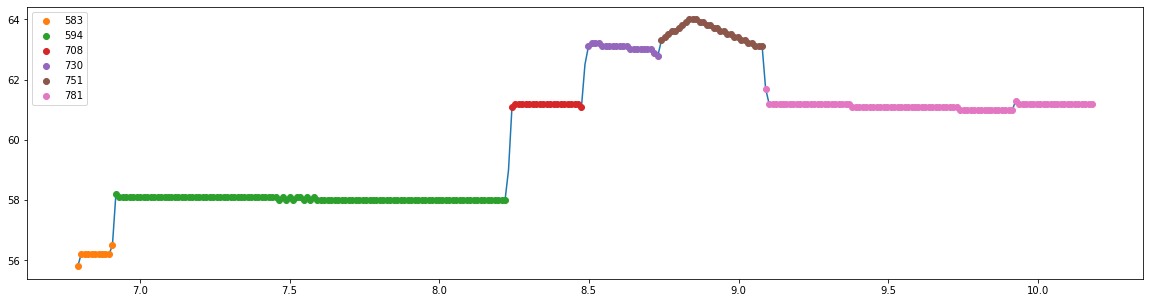

In [10]:
# example: the first F0 segment (293 frames)
f0_segment = f0_segments[0]
note_events = get_note_events_from_f0_segment(notes, f0_segment)

plt.figure(figsize=(20,5))
plt.plot(times[f0_segment], notes[f0_segment])
for note_event in note_events:
    plt.plot(times[note_event], notes[note_event], 'o', label=note_event[0])
plt.legend()
plt.show()

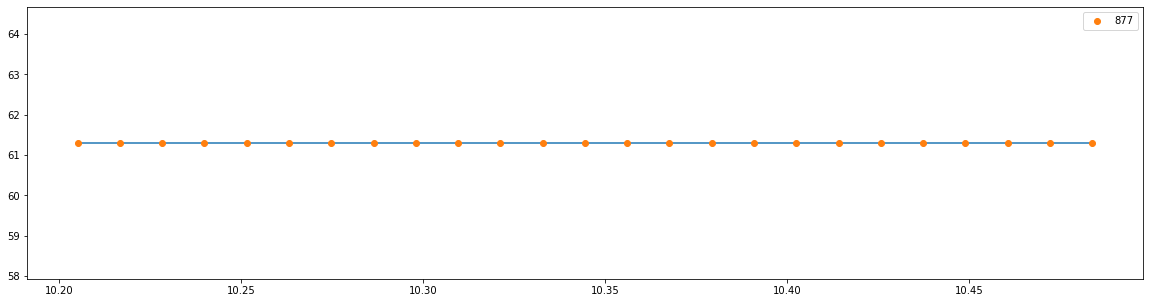

In [11]:
f0_segment = f0_segments[1]
note_events = get_note_events_from_f0_segment(notes, f0_segment)

plt.figure(figsize=(20,5))
plt.plot(times[f0_segment], notes[f0_segment])
for note_event in note_events:
    plt.plot(times[note_event], notes[note_event], 'o', label=note_event[0])
plt.legend()
plt.show()

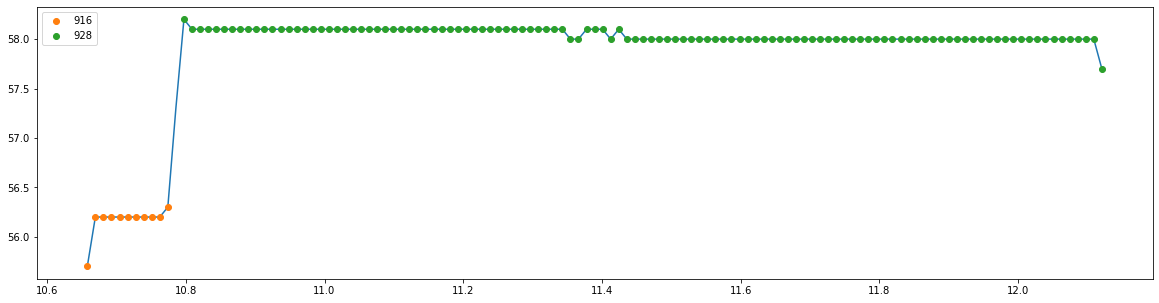

In [12]:
f0_segment = f0_segments[2]
note_events = get_note_events_from_f0_segment(notes, f0_segment)

plt.figure(figsize=(20,5))
plt.plot(times[f0_segment], notes[f0_segment])
for note_event in note_events:
    plt.plot(times[note_event], notes[note_event], 'o', label=note_event[0])
plt.legend()
plt.show()

In [76]:
anno_file = find_anno(file)
with open(anno_file) as anno:
    anno = json.load(anno)
anno

[{'time': {'start': 6.7742, 'dur': 0.121},
  'string': 4,
  'fret': 7,
  'pitch': 56,
  'type': 'normal',
  'effects': {'hammer': True,
   'mute': False,
   'vibrato': False,
   'harmonic': False,
   'slide': False,
   'bend': False,
   'grace': False,
   'bend_type': None,
   'bend_value': None,
   'slide_types': None,
   'grace_dur': None,
   'grace_fret': None,
   'grace_trans': None}},
 {'time': {'start': 6.8952, 'dur': 1.3306},
  'string': 4,
  'fret': 9,
  'pitch': 58,
  'type': 'normal',
  'effects': {'hammer': False,
   'mute': False,
   'vibrato': False,
   'harmonic': False,
   'slide': False,
   'bend': False,
   'grace': False,
   'bend_type': None,
   'bend_value': None,
   'slide_types': None,
   'grace_dur': None,
   'grace_fret': None,
   'grace_trans': None}},
 {'time': {'start': 8.2258, 'dur': 0.2419},
  'string': 3,
  'fret': 7,
  'pitch': 61,
  'type': 'normal',
  'effects': {'hammer': False,
   'mute': False,
   'vibrato': False,
   'harmonic': False,
   'slide': F

### Candidate selection rules
The final classification will be on the note event level (aggregate frame-level features over the duration of the note event)

Not all note events go into training/testing. Only candidates do that. 

Candidate selection objective is to select the note events that satisfies detection rules. This include both true-positives and false-positives, which are further classified by SVM. The SVM is specifically trained to distiguish between true positives and false positives. 

**VIBRATO**
* Mean filtering? 
* Four consecutive local extrema within a note event
* Distance between consecutive extrema should be around 30-400ms, for a reasonable vibrato rate
* Pitch difference between adjacent extrema should be smaller than 225 cents (slight larger than a whole note)
  
**BEND**
* Pitch should be going up/down for more than 80ms
* Pitch difference between two consecutive frames should be smaller than 50 cents.

In [14]:
# `get_continuous_f0_segments` returns segments longer than 80ms
f0_segments = get_continous_f0_segments(notes)
# master_note_events contains valid note events from all valid F0 segments in an audio file (mono audio segment)
master_note_events = []
for f0_segment in f0_segments:
    note_events = get_note_events_from_f0_segment(notes, f0_segment)
    master_note_events.extend(note_events)

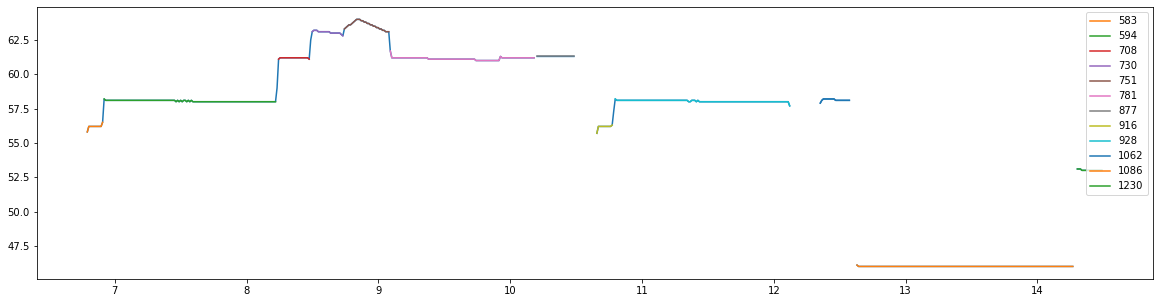

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(times, notes)
# plot all valid note events in this example audio file
for note_event in master_note_events:
    assert len(note_event) >= 4
    plt.plot(times[note_event], notes[note_event], label=note_event[0])
plt.legend()

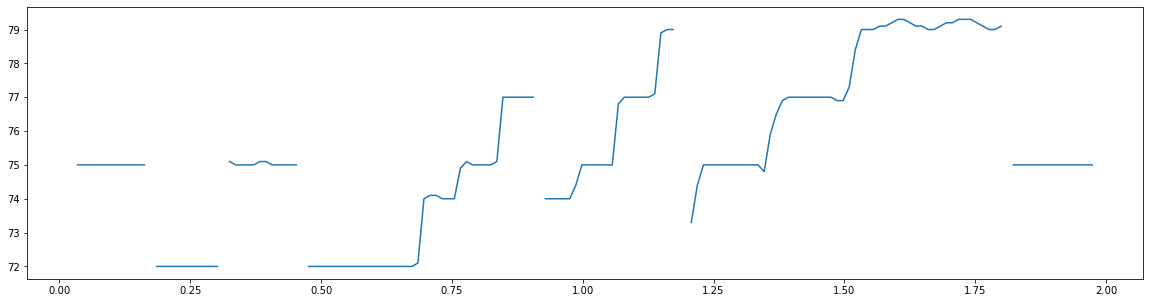

In [16]:
# the directory for preprocessed audio files (mono audio segments that has a reasonable length)
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/mono_audio_segments_filtered"

# vibrato example
file = "DragonForce - Through The Fire And Flames_Lead 1_0_0s.wav"
y, sr = librosa.load(os.path.join(FILTERED_AUDIO_DIR, file), sr=None)

# the vibrato is at 28.5-28.8s
y = y[27*sr: 29*sr]

f0, _, _ = librosa.pyin(
    y, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("G6"), sr=sr, center=False
)
times = librosa.times_like(f0, sr=sr, hop_length=512, n_fft=2048)
# convert F0 sequence to MIDI note sequence
notes = librosa.hz_to_midi(f0)

plt.figure(figsize=(20, 5))
plt.plot(times, notes)

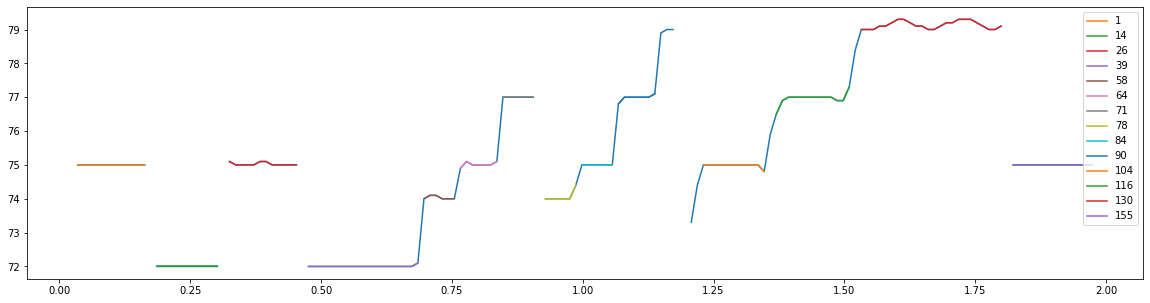

In [17]:
f0_segments = get_continous_f0_segments(notes)
# master_note_events contains valid note events from all valid F0 segments in an audio file (mono audio segment)
master_note_events = []
for f0_segment in f0_segments:
    note_events = get_note_events_from_f0_segment(notes, f0_segment)
    master_note_events.extend(note_events)

plt.figure(figsize=(20, 5))
plt.plot(times, notes)
# plot all valid note events in this example audio file
for note_event in master_note_events:
    assert len(note_event) >= 4
    plt.plot(times[note_event], notes[note_event], label=note_event[0])
plt.legend()

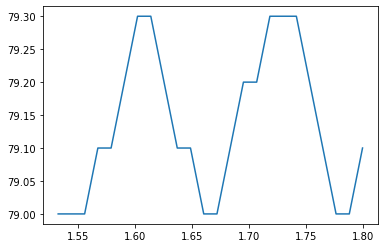

In [18]:
plt.plot(times[master_note_events[-2]], notes[master_note_events[-2]])
# this "slight" vibrato: peak - trough = 0.3

In [ ]:
for i in master_note_events:
    n = notes[i]
    print(is_vibrato_candidate(n))